In [1]:
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt

In [2]:
# This script describes the functionality of the flat-sky version of pymaster

# Dimensions:
# First, a flat-sky field is defined by four quantities:
#  - Lx and Ly: the size of the patch in the x and y dimensions (in radians)
Lx = 20. * np.pi/180
Ly = 20. * np.pi/180
#  - Nx and Ny: the number of pixels in the x and y dimensions
Nx = 800
Ny = 800

In [3]:
import pickle
from scipy.interpolate import interp1d
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

#unlensed
L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedEE = unlensedCL[:,1]
F = unlensedEE
funlensedEE = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedBB = unlensedCL[:,2]
F = unlensedBB
funlensedBB = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedTE = unlensedCL[:,3]
F = unlensedTE
funlensedTE = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [4]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP
rawKK = np.nan_to_num(rawKK, nan=0)

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


/tmp/ipykernel_2292/779987732.py:12: RuntimeWarning: invalid value encountered in divide
  unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
/tmp/ipykernel_2292/779987732.py:18: RuntimeWarning: invalid value encountered in divide
  rawPP = PP*2*np.pi/((L*(L+1))**2)
/tmp/ipykernel_2292/779987732.py:26: RuntimeWarning: invalid value encountered in divide
  lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
/tmp/ipykernel_2292/779987732.py:36: RuntimeWarning: invalid value encountered in divide
  cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi


In [5]:
mpk = nmt.synfast_flat(Nx, Ny, Lx, Ly,
                       [rawKK],
                       [0])[0]


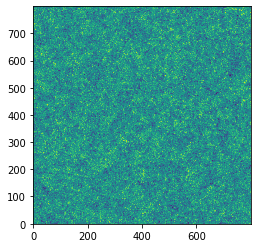

In [6]:
plt.imshow(mpk, interpolation='nearest', origin='lower')

In [7]:

# In[15]:
import sys

#######

N_RUNS = 10
import warnings
warnings.filterwarnings("ignore")
#####


# In[2]:


import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))


# In[3]:


from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


# In[4]:


print("Map properties")

# number of pixels for the flat map
nX = 800
nY = 800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra


# In[5]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: ftot(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

Map properties
CMB experiment properties


In [8]:
kCmbFourier = baseMap.genGRF(fKK, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

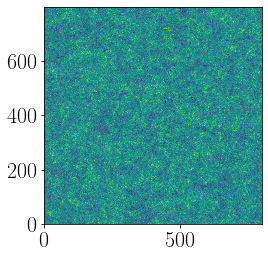

In [9]:
plt.imshow(kCmb, interpolation='nearest', origin='lower')

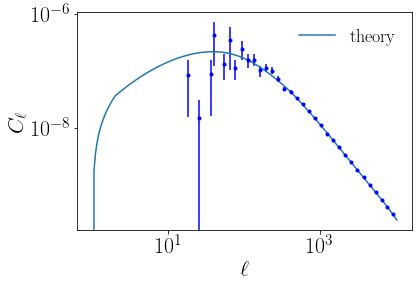

In [12]:
baseMap.powerSpectrum(dataFourier=kCmbFourier, plot=True, theory=[fKK]);

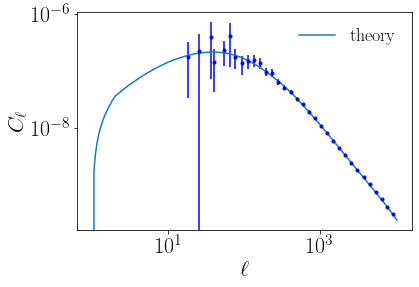

In [13]:
mpkFourier = baseMap.fourier(mpk);
baseMap.powerSpectrum(dataFourier=mpkFourier, plot=True, theory=[fKK]);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


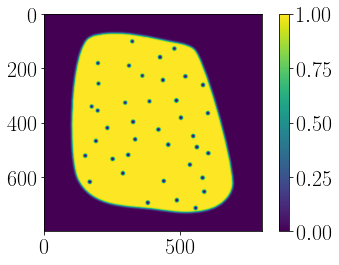

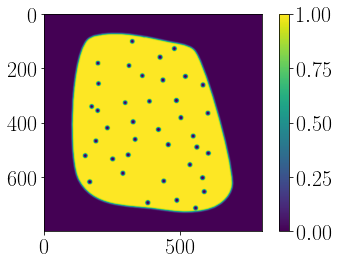

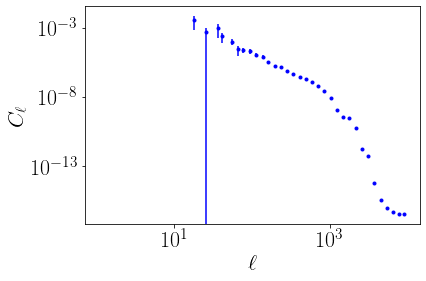

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


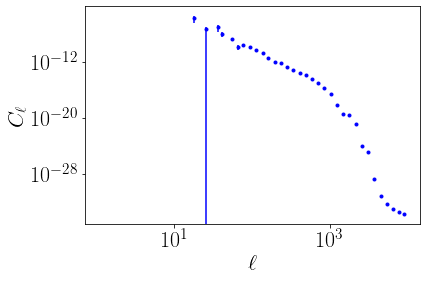

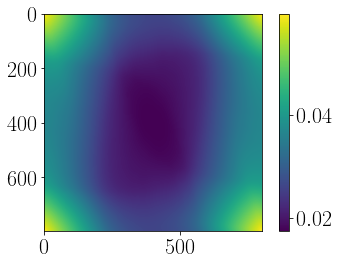

In [14]:
mask_file = 'mask_simple800x800.png'
psfile = 'point_sources_800x800.png'
psapod = 2


#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread(mask_file))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread(psfile))
point_sources = gaussian_filter(point_sources, psapod) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)
plt.figure()
plt.imshow(apodized_mask, vmin=0, vmax=1)
plt.colorbar()
plt.savefig('figures/apodized_masked_%dx%d.pdf'%(nX, nY),bbox_inches='tight')

plt.figure()
plt.imshow(apodized_mask**2, vmin=0, vmax=1)
plt.colorbar()

maskFourier = baseMap.fourier(apodized_mask)
baseMap.powerSpectrum(maskFourier, plot=True)

mask2Fourier = (maskFourier*np.conj(maskFourier))
baseMap.powerSpectrum(mask2Fourier, plot=True)

approxmask = baseMap.inverseFourier(mask2Fourier)
plt.figure()
plt.imshow(approxmask)#, vmin=0, vmax=1)
plt.colorbar()



In [15]:
f0 = nmt.NmtFieldFlat(Lx, Ly, apodized_mask**2, [kCmb])
# Bins:
# For flat-sky fields, bandpowers are simply defined as intervals in ell, and
# pymaster doesn't currently support any weighting scheme within each interval.
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, lf_bins)
# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)


In [16]:
# Bins:
# For flat-sky fields, bandpowers are simply defined as intervals in ell, and
# pymaster doesn't currently support any weighting scheme within each interval.
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, lf_bins)
# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

In [17]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)


In [18]:
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)

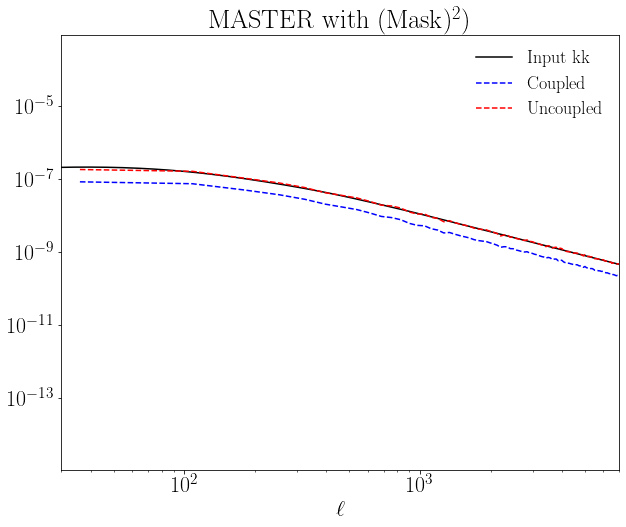

In [20]:
plt.figure(figsize=(10,8))
L = np.arange(cl.shape[0])
plt.title(r'MASTER with $({\rm Mask})^2)$')
plt.xlabel(r'$\ell$')
plt.plot(L, rawKK, 'k', label='Input kk')
plt.plot(ells_uncoupled, cl00_coupled[0], 'b--', label='Coupled')

plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r--', label='Uncoupled')

plt.loglog()
plt.xlim(lMin,2*lMax)
plt.ylim(1.1e-15,.9e-3)
plt.legend(frameon=False)


In [21]:
fsky = np.sum(apodized_mask) / np.sum(np.ones_like(apodized_mask))

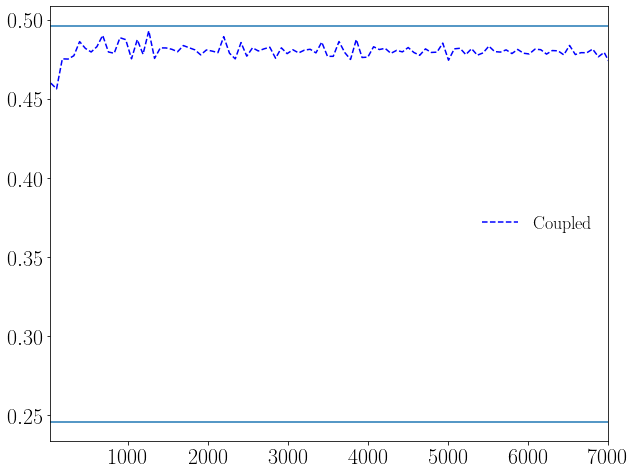

In [27]:
plt.figure(figsize=(10,8))
L = np.arange(cl.shape[0])
plt.plot(ells_uncoupled, cl00_coupled[0]/cl00_uncoupled[0], 'b--', label='Coupled')
plt.axhline(fsky)
plt.axhline(fsky**2)

plt.xlim(lMin,2*lMax)
plt.legend(frameon=False)